## 1D + 2D Convolutions

Much to my disappointment, I wasn't able to get 3D convolutions to perform very well on our data. It's possible that I should have used a larger dataset or I implemented something incorrectly. Either way, let's try a new approach:

1D + 2D Convolutions

In [1]:
import torch
import numpy as np
from fastai.core import *
from fastai.vision import *
import matplotlib.pyplot as plt

In [2]:
path = Path('../data/hard_video_frames')

In [3]:
def open_video_frames_as_image(self, filename):
    # Open frames
    frames = np.load(filename)
        
    # Convert to tensor and normalize
    frames_tensor = torch.from_numpy(frames).float()
    frames_tensor.div_(255)
    
    frames_tensor = frames_tensor.permute(2, 0, 1)
    
    return Image(frames_tensor)
    
ImageList.open = open_video_frames_as_image

In [4]:
src = ImageList.from_folder(path, extensions='.npy').split_by_folder(train='train', valid='val')
src

ItemLists;

Train: ImageList (799 items)
Image (48, 164, 149),Image (48, 211, 206),Image (48, 277, 289),Image (48, 250, 241),Image (48, 237, 251)
Path: ../data/hard_video_frames;

Valid: ImageList (200 items)
Image (48, 255, 240),Image (48, 231, 230),Image (48, 239, 241),Image (48, 219, 236),Image (48, 108, 87)
Path: ../data/hard_video_frames;

Test: None

In [5]:
def get_data(bs,size):
    data = (src.label_from_re('([A-Z]+).npy$')
           .transform(get_transforms(max_warp=0, max_zoom=1), size=size)
           .databunch(bs=bs))
    #TODO: Normalize somehow
    return data

In [6]:
bs, sz = 8, 128
data = get_data(bs, sz)

In [7]:
import math

import torch.nn as nn
from torch.nn.modules.utils import _triple


class SpatioTemporalConv(nn.Module):
    r"""Applies a factored 3D convolution over an input signal composed of several input 
    planes with distinct spatial and time axes, by performing a 2D convolution over the 
    spatial axes to an intermediate subspace, followed by a 1D convolution over the time 
    axis to produce the final output.
    Args:
        in_channels (int): Number of channels in the input tensor
        out_channels (int): Number of channels produced by the convolution
        kernel_size (int or tuple): Size of the convolving kernel
        stride (int or tuple, optional): Stride of the convolution. Default: 1
        padding (int or tuple, optional): Zero-padding added to the sides of the input during their respective convolutions. Default: 0
        bias (bool, optional): If ``True``, adds a learnable bias to the output. Default: ``True``
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, bias=True):
        super(SpatioTemporalConv, self).__init__()

        # if ints are entered, convert them to iterables, 1 -> [1, 1, 1]
        kernel_size = _triple(kernel_size)
        stride = _triple(stride)
        padding = _triple(padding)

        # decomposing the parameters into spatial and temporal components by
        # masking out the values with the defaults on the axis that
        # won't be convolved over. This is necessary to avoid unintentional
        # behavior such as padding being added twice
        spatial_kernel_size =  [1, kernel_size[1], kernel_size[2]]
        spatial_stride =  [1, stride[1], stride[2]]
        spatial_padding =  [0, padding[1], padding[2]]

        temporal_kernel_size = [kernel_size[0], 1, 1]
        temporal_stride =  [stride[0], 1, 1]
        temporal_padding =  [padding[0], 0, 0]

        # compute the number of intermediary channels (M) using formula 
        # from the paper section 3.5
        intermed_channels = int(math.floor((kernel_size[0] * kernel_size[1] * kernel_size[2] * in_channels * out_channels)/ \
                            (kernel_size[1]* kernel_size[2] * in_channels + kernel_size[0] * out_channels)))

        # the spatial conv is effectively a 2D conv due to the 
        # spatial_kernel_size, followed by batch_norm and ReLU
        self.spatial_conv = nn.Conv3d(in_channels, intermed_channels, spatial_kernel_size,
                                    stride=spatial_stride, padding=spatial_padding, bias=bias)
        self.bn = nn.BatchNorm3d(intermed_channels)
        self.relu = nn.ReLU(inplace=True)

        # the temporal conv is effectively a 1D conv, but has batch norm 
        # and ReLU added inside the model constructor, not here. This is an 
        # intentional design choice, to allow this module to externally act 
        # identical to a standard Conv3D, so it can be reused easily in any 
        # other codebase
        self.temporal_conv = nn.Conv3d(intermed_channels, out_channels, temporal_kernel_size, 
                                    stride=temporal_stride, padding=temporal_padding, bias=bias)

    def forward(self, x):
        x = self.relu(self.bn(self.spatial_conv(x)))
        x = self.temporal_conv(x)
        return x
    


In [8]:
import torch.nn as nn
from torch.nn.modules.utils import _triple


class SpatioTemporalResBlock(nn.Module):
    r"""Single block for the ResNet network. Uses SpatioTemporalConv in 
        the standard ResNet block layout (conv->batchnorm->ReLU->conv->batchnorm->sum->ReLU)
        
        Args:
            in_channels (int): Number of channels in the input tensor.
            out_channels (int): Number of channels in the output produced by the block.
            kernel_size (int or tuple): Size of the convolving kernels.
            downsample (bool, optional): If ``True``, the output size is to be smaller than the input. Default: ``False``
        """
    def __init__(self, in_channels, out_channels, kernel_size, downsample=False):
        super(SpatioTemporalResBlock, self).__init__()
        
        # If downsample == True, the first conv of the layer has stride = 2 
        # to halve the residual output size, and the input x is passed 
        # through a seperate 1x1x1 conv with stride = 2 to also halve it.

        # no pooling layers are used inside ResNet
        self.downsample = downsample
        
        # to allow for SAME padding
        padding = kernel_size//2

        if self.downsample:
            # downsample with stride =2 the input x
            self.downsampleconv = SpatioTemporalConv(in_channels, out_channels, 1, stride=2)
            self.downsamplebn = nn.BatchNorm3d(out_channels)

            # downsample with stride = 2when producing the residual
            self.conv1 = SpatioTemporalConv(in_channels, out_channels, kernel_size, padding=padding, stride=2)
        else:
            self.conv1 = SpatioTemporalConv(in_channels, out_channels, kernel_size, padding=padding)

        self.bn1 = nn.BatchNorm3d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)

        # standard conv->batchnorm->ReLU
        self.conv2 = SpatioTemporalConv(out_channels, out_channels, kernel_size, padding=padding)
        self.bn2 = nn.BatchNorm3d(out_channels)
        self.outrelu = nn.ReLU(inplace=True)

    def forward(self, x):
        res = self.relu1(self.bn1(self.conv1(x)))    
        res = self.bn2(self.conv2(res))

        if self.downsample:
            x = self.downsamplebn(self.downsampleconv(x))

        return self.outrelu(x + res)


class SpatioTemporalResLayer(nn.Module):
    r"""Forms a single layer of the ResNet network, with a number of repeating 
    blocks of same output size stacked on top of each other
        
        Args:
            in_channels (int): Number of channels in the input tensor.
            out_channels (int): Number of channels in the output produced by the layer.
            kernel_size (int or tuple): Size of the convolving kernels.
            layer_size (int): Number of blocks to be stacked to form the layer
            block_type (Module, optional): Type of block that is to be used to form the layer. Default: SpatioTemporalResBlock. 
            downsample (bool, optional): If ``True``, the first block in layer will implement downsampling. Default: ``False``
        """

    def __init__(self, in_channels, out_channels, kernel_size, layer_size, block_type=SpatioTemporalResBlock, downsample=False):
        
        super(SpatioTemporalResLayer, self).__init__()

        # implement the first block
        self.block1 = block_type(in_channels, out_channels, kernel_size, downsample)

        # prepare module list to hold all (layer_size - 1) blocks
        self.blocks = nn.ModuleList([])
        for i in range(layer_size - 1):
            # all these blocks are identical, and have downsample = False by default
            self.blocks += [block_type(out_channels, out_channels, kernel_size)]

    def forward(self, x):
        x = self.block1(x)
        for block in self.blocks:
            x = block(x)

        return x


class R2Plus1DNet(nn.Module):
    r"""Forms the overall ResNet feature extractor by initializng 5 layers, with the number of blocks in 
    each layer set by layer_sizes, and by performing a global average pool at the end producing a 
    512-dimensional vector for each element in the batch.
        
        Args:
            layer_sizes (tuple): An iterable containing the number of blocks in each layer
            block_type (Module, optional): Type of block that is to be used to form the layers. Default: SpatioTemporalResBlock. 
        """
    def __init__(self, layer_sizes, block_type=SpatioTemporalResBlock):
        super(R2Plus1DNet, self).__init__()

        # first conv, with stride 1x2x2 and kernel size 3x7x7
        self.conv1 = SpatioTemporalConv(3, 64, [3, 7, 7], stride=[1, 2, 2], padding=[1, 3, 3])
        # output of conv2 is same size as of conv1, no downsampling needed. kernel_size 3x3x3
        self.conv2 = SpatioTemporalResLayer(64, 64, 3, layer_sizes[0], block_type=block_type)
        # each of the final three layers doubles num_channels, while performing downsampling 
        # inside the first block
        self.conv3 = SpatioTemporalResLayer(64, 128, 3, layer_sizes[1], block_type=block_type, downsample=True)
        self.conv4 = SpatioTemporalResLayer(128, 256, 3, layer_sizes[2], block_type=block_type, downsample=True)
        self.conv5 = SpatioTemporalResLayer(256, 512, 3, layer_sizes[3], block_type=block_type, downsample=True)

        # global average pooling of the output
        self.pool = nn.AdaptiveAvgPool3d(1)
    
    def forward(self, x):
        #Reshape inputs
        x = x.reshape(bs, 16, 3, sz, sz).permute(0, 2, 1, 3, 4)
        x = x.cuda()
        
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = self.pool(x)
        
        return x.view(-1, 512)

class R2Plus1DClassifier(nn.Module):
    r"""Forms a complete ResNet classifier producing vectors of size num_classes, by initializng 5 layers, 
    with the number of blocks in each layer set by layer_sizes, and by performing a global average pool
    at the end producing a 512-dimensional vector for each element in the batch, 
    and passing them through a Linear layer.
        
        Args:
            num_classes(int): Number of classes in the data
            layer_sizes (tuple): An iterable containing the number of blocks in each layer
            block_type (Module, optional): Type of block that is to be used to form the layers. Default: SpatioTemporalResBlock. 
        """
    def __init__(self, num_classes, layer_sizes, block_type=SpatioTemporalResBlock):
        super(R2Plus1DClassifier, self).__init__()

        self.res2plus1d = R2Plus1DNet(layer_sizes, block_type)
        self.linear = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.res2plus1d(x)
        x = self.linear(x) 

        return x   

In [15]:
model = R2Plus1DClassifier(num_classes=2, layer_sizes=[2, 2, 2, 2])
model = model.cuda()

In [16]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [17]:
count_parameters(model)

33192736

In [20]:
# Create a learner and group parameters 
learner = Learner(data, model, metrics=[accuracy])

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


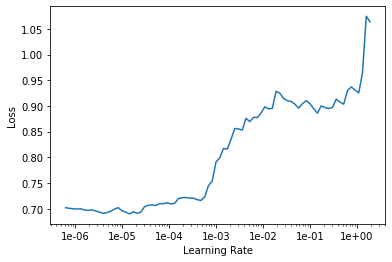

In [21]:
learner.lr_find()
learner.recorder.plot()

In [22]:
learner.fit_one_cycle(20, 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.700502,0.692656,0.525000,01:31
1,0.710197,0.698418,0.520000,01:29
2,0.710076,0.723940,0.530000,01:23
3,0.710508,0.804434,0.500000,01:22
4,0.724642,0.710988,0.490000,01:23
5,0.725100,0.704859,0.510000,01:23
6,0.713961,0.742768,0.500000,01:23
7,0.708882,0.709511,0.515000,01:23
8,0.706040,0.699667,0.505000,01:22
9,0.709146,0.702660,0.510000,01:22


In [23]:
learner.fit_one_cycle(20, 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.688949,0.696552,0.520000,01:23
1,0.696882,0.695273,0.490000,01:22
2,0.698691,0.707367,0.500000,01:23
3,0.703560,0.729542,0.460000,01:22
4,0.704276,0.706857,0.490000,01:23
5,0.700763,0.707648,0.500000,01:22


KeyboardInterrupt: 